<a href="https://colab.research.google.com/github/ankitstar01/DeepLearning/blob/master/Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install polygon-api-client 
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from polygon import RESTClient
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

In [6]:
api_key = 'vqeohd8x5k1x6PKiisJQS8RgS3A1iRQC'
TIME_HORIZON = 10
current_day = datetime.today().strftime('%Y-%m-%d')
loss_function = 'mean_squared_error'
activation_function = 'relu'
optimizer = 'adam'
record_limit = 50000
timespan = 'minute'
asc_sorting_order = 'asc'
desc_sorting_order = 'desc'
start_date = (datetime.today() - timedelta(days=80)).strftime('%Y-%m-%d')
to_date = (datetime.today() - timedelta(days=2)).strftime('%Y-%m-%d')

# folder path variables
model_folder_path = 'Models/'
historic_folder_path = 'Data/Historic/'
recent_folder_path = 'Data/Recent/'
file_extension = '.csv'
historic_file_header = 'timestamp,open,low,high,volume,close\n'
recent_file_header = 'open,low,high,volume,close\n'

# plot variables
stock_price_label = 'Stock Price'
real_label = 'Real'
predicted_label = 'Predicted'
x_label = 'time'
answers_colour = 'r'
prediction_colour = 'c'

ticker = 'GME'
time_horizon = 10
time_span = 'minute'
key = 'vqeohd8x5k1x6PKiisJQS8RgS3A1iRQC'

In [7]:

def get_historic_data(ticker, time_horizon, time_span, key):
    f = open(historic_folder_path + ticker + file_extension, 'w')
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=time_horizon, timespan=time_span,
                                                 from_=start_date, to=to_date, unadjusted=False,
                                                 sort=asc_sorting_order, limit=record_limit)
        resp = resp.results
        f.write(historic_file_header)
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()
    f = open(historic_folder_path + ticker + file_extension, 'r')
    df = pd.read_csv(f)
    return df

In [68]:

def preprocess_training_data(training_df):
    training_df = training_df.drop(['timestamp'], axis=1)
    scaler = MinMaxScaler()
    scaler_df = training_df.copy()
    scaler.fit_transform(scaler_df)
    scaler = scaler.scale_
    training_df['open'] *= scaler[0]
    training_df['low'] *= scaler[1]
    training_df['high'] *= scaler[2]
    training_df['volume'] *= scaler[3]
    training_df['close'] *= scaler[4]

    x_train, y_train = [], []
    training_df = np.asarray(training_df)
    for i in range(15, training_df.shape[0]):
        x_train.append(training_df[i - 15: i])
        y_train.append(training_df[i, 0])
    x_train, y_train,xv,yv , x_test,y_test = np.asarray(x_train[:-120]), np.asarray(y_train[:-120]),np.array(x_train[-120:-60]), np.array(y_train[-120:-60]),np.asarray(x_train[-60:]), np.asarray(y_train[-60:])
    return x_train, y_train,xv,yv,x_test,y_test, scaler

In [71]:

def get_recent_data(ticker, key, time_horizon, time_span):
    f = open(recent_folder_path + ticker + file_extension, 'w')
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=time_horizon, timespan=time_span,
                                                 from_=to_date, to=current_day, unadjusted=False,
                                                 sort=asc_sorting_order, limit=record_limit)
        resp = resp.results
        f.write(historic_file_header)
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()

def update_recent_data(ticker, key, time_horizon, time_span):
    f = open(recent_folder_path + ticker + file_extension, 'a')
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=time_horizon, timespan=time_span,
                                                 from_=to_date, to=current_day, unadjusted=False,
                                                 sort=desc_sorting_order, limit=record_limit)
        query = resp.results[0]
        f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()
    f = open(recent_folder_path + ticker + file_extension, 'r')
    entry_price = query['o']
    recent_df = pd.read_csv(f)
    return recent_df, entry_price

def preprocess_recent_data(recent_df, scaler):
    recent_df = recent_df.drop(['timestamp'], axis=1)
    recent_df['open'] *= scaler[0]
    recent_df['low'] *= scaler[1]
    recent_df['high'] *= scaler[2]
    recent_df['volume'] *= scaler[3]
    recent_df['close'] *= scaler[4]
    df = [recent_df[-15:]]
    df = np.asarray(df)
    return df
def visualize_model(predictions, answers, ticker):
    plt.figure(figsize=(15, 5))
    plt.plot(answers, c=answers_colour, label=real_label + ' ' + ticker + ' ' + stock_price_label)
    plt.plot(predictions, c=prediction_colour, label=predicted_label + ' ' + ticker + ' ' + stock_price_label)
    plt.xlabel(x_label)
    plt.ylabel(ticker + ' ' + stock_price_label)
    plt.legend()
    plt.show()

def create_model(ticker, training_input, training_output, scaler):
    model = Sequential()
    model.add(LSTM(units=50, activation=activation_function, input_shape=(15, 5), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=80, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=100, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=120, activation=activation_function, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_function)
    es=EarlyStopping(monitor='val_loss',mode='min',patience=5,verbose=1)
    model.fit(training_input, training_output,validation_data=(xv,yv), epochs=100, batch_size=32,verbose=1,callbacks=[es])
    model.save(model_folder_path + ticker)
    predictions = model.predict(training_input) 
    answers = training_output 

    return predictions, answers

In [64]:
# !mkdir data
# !cd data

def get_prediction(model, scaler, last_data):
    prediction = model.predict(last_data)
    prediction *= 1/scaler[0]
    return prediction

def convert_timestamp(timestamp):
    return datetime.fromtimestamp(timestamp/1000)

In [75]:
df=pd.read_csv('data/Historic/dayAMC.csv')
df['timestamp']=df['timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
df.head(51*5)

,timestamp,open,low,high,volume,close
0,2013-12-18 05:00:00,19.18,18.90,19.790,15026951.0,18.90
1,2013-12-19 05:00:00,18.90,18.81,19.490,1607724.0,19.49
2,2013-12-20 05:00:00,19.65,19.40,19.770,737927.0,19.68
3,2013-12-23 05:00:00,19.79,19.50,19.990,698342.0,19.74
4,2013-12-24 05:00:00,19.74,19.50,19.820,213859.0,19.53
...,...,...,...,...,...,...
250,2014-12-16 05:00:00,24.98,24.19,24.995,207040.0,24.20
251,2014-12-17 05:00:00,24.64,24.21,25.630,481346.0,25.40
252,2014-12-18 05:00:00,25.74,25.45,26.170,315352.0,25.91
253,2014-12-19 05:00:00,25.92,25.88,26.570,530344.0,26.17


In [76]:
x_train, y_train,xv,yv,x_test,y_test, scaler = preprocess_training_data(df)
print(x_train.shape,xv.shape,x_test.shape)
print(y_train.shape,yv.shape,y_test.shape)
print(scaler)

(1665, 15, 5) (60, 15, 5) (60, 15, 5)
(1665,) (60,) (60,)
[2.95508274e-02 2.96647879e-02 2.93255132e-02 7.95953376e-10
 2.95159386e-02]


In [77]:
predictions, answers = create_model(ticker, x_train, y_train, scaler)

Epoch 1/100
53/53 [==============================] - 9s 68ms/step - loss: 0.1709 - val_loss: 0.0188
Epoch 2/100
53/53 [==============================] - 3s 56ms/step - loss: 0.0100 - val_loss: 0.0085
Epoch 3/100
53/53 [==============================] - 3s 56ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 4/100
53/53 [==============================] - 3s 56ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 5/100
53/53 [==============================] - 3s 56ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 6/100
53/53 [==============================] - 3s 56ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 7/100
53/53 [==============================] - 3s 56ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 8/100
53/53 [==============================] - 3s 56ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 9/100
53/53 [==============================] - 3s 56ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 10/100
53/53 [==============================] - 3s 56ms/step - loss: 0.0032 - val_loss: 0.0015

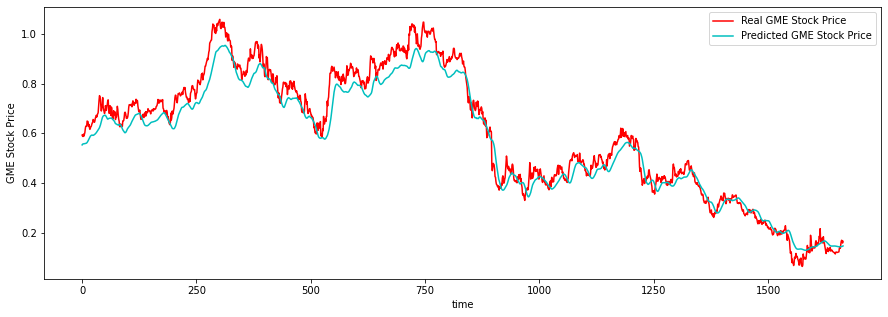

In [78]:
visualize_model(predictions, answers, ticker)

In [40]:
model = keras.models.load_model('Models/' + ticker)
model.evaluate(x_test,y_test)

1/1 [==============================] - 1s 731ms/step - loss: 0.0256


0.0256170853972435

In [ ]:
model.save('models/' + ticker)

INFO:tensorflow:Assets written to: models/GME/assets


In [ ]:
def update_data(ticker, api_key):
    f = open('ticker_folder/' + ticker + '.csv','a')
    with RESTClient(api_key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=10, timespan='minute',
                                                 from_='2021-02-04', to='2021-02-04', unadjusted=False,
                                                 sort='asc', limit=50000)
        resp = resp.results
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()
    f = open('ticker_folder/' + ticker + '.csv', 'r')
    df = pd.read_csv(f)
    return df

In [ ]:
df2 = update_data(ticker, API_KEY)
df2.tail()

,timestamp,open,low,high,volume,close
3191,1612483800000,50.18,50.13,50.94,33918.0,50.13
3192,1612484400000,50.13,49.56,50.75,56667.0,50.51
3193,1612485000000,50.73,50.10,50.73,32266.0,50.10
3194,1612485600000,50.10,49.50,50.10,56866.0,49.60
3195,1612486200000,49.60,49.00,49.69,123666.0,49.17


In [ ]:
df2 = df2.drop(["timestamp"], axis=1)
df2.tail()

,open,low,high,volume,close
3191,50.18,50.13,50.94,33918.0,50.13
3192,50.13,49.56,50.75,56667.0,50.51
3193,50.73,50.10,50.73,32266.0,50.10
3194,50.10,49.50,50.10,56866.0,49.60
3195,49.60,49.00,49.69,123666.0,49.17


In [ ]:
model = keras.models.load_model('models/' + ticker)
x_train, y_train, x_test, y_test, scaler = split_data(df2)
predictions = model.predict(x_test)

In [ ]:
scale = 1 / scaler
predictions = predictions * scale
y_test = y_test * scale

plt.figure(figsize=(14, 5))
plt.plot(y_test, c='r', label='Real ' + ticker + ' stock price')
plt.plot(predictions, c='b', label='Predicted ' + ticker + ' stock price')
plt.xlabel('time')
plt.ylabel(ticker + ' Stock Price')
plt.legend()
plt.show()

In [57]:
df[-90:-60]

,timestamp,open,low,high,volume,close
1710,2020-10-05 04:00:00,4.3000,4.0500,4.3600,9604945.0,4.13
1711,2020-10-06 04:00:00,4.2600,4.0500,4.2700,8474681.0,4.06
1712,2020-10-07 04:00:00,4.0800,3.9400,4.1100,6988571.0,4.04
1713,2020-10-08 04:00:00,4.1300,4.0200,4.1850,8018632.0,4.14
1714,2020-10-09 04:00:00,4.1700,4.0400,4.1800,5107596.0,4.05
1715,2020-10-12 04:00:00,4.0300,4.0000,4.0900,3312043.0,4.08
1716,2020-10-13 04:00:00,3.9000,3.5200,3.9100,10342266.0,3.54
1717,2020-10-14 04:00:00,3.0900,2.6600,3.2000,32142195.0,2.96
1718,2020-10-15 04:00:00,2.8400,2.7600,2.9600,9949311.0,2.78
1719,2020-10-16 04:00:00,2.8700,2.8000,3.2900,18665138.0,3.04


In [ ]:
def get_minute_data(ticker, api_key, last_minutes):  # gets minute by minute data for last (last_minutes) minutes
    f = open('recent_ticker_data/' + ticker + '.csv', 'w')
    with RESTClient(api_key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=1, timespan='minute',
                                                 from_='1999-07-12', to='2021-02-04', unadjusted=False,
                                                 sort='desc', limit=last_minutes)
        resp = resp.results
        f.write('timestamp,open,low,high,volume,close\n')
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ',' + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
        f.close()
    f = open('recent_ticker_data/' + ticker + '.csv', 'r')
    df = pd.read_csv(f)
    return df

In [ ]:
df = get_minute_data('GME', API_KEY, 60)
df.head()

,timestamp,open,low,high,volume,close
0,1612486740000,49.00,49.00,49.48,29415,49.17
1,1612486680000,49.02,49.00,49.10,22745,49.01
2,1612486620000,49.25,49.01,49.25,21123,49.02
3,1612486560000,49.40,49.20,49.40,13707,49.20
4,1612486500000,49.41,49.40,49.56,10718,49.41


In [ ]:
def get_all_news(ticker, api_key):  # function works on pycharm, however google colab cannot open the csv file
    f = open(ticker + '_news.csv', 'w')
    f.write('date,title\n')
    with RESTClient(api_key) as client:
        for j in range(25):
            resp = client.reference_ticker_news(symbol=ticker, perpage=50, page=j)
            for i in range(50):
                f.write(resp.news[i].timestamp + ',' + resp.news[i].title + '\n')
    f.close()

In [ ]:
def get_polarity(headline):
    analysis = TextBlob(headline)
    return analysis.polarity

In [ ]:
polarity = get_polarity('GME is a good stock to buy')
print('polarity: ' + str(polarity))

polarity: 0.7
